# O intuito desse arquivo é realizar a Analise de Resultados Esperados da apresentção do projeto.

Uma vez que foi concluido que o ponto chave para a troca entre aluguel e venda é de 4 anos, a análise de resultados esperados é a seguinte:
 - Queremos filtrar todos os carro fabricados a partir de 2018, e simular a receita que seria obtida com o aluguel do carro por 4 anos e depois a venda do mesmo. Para assim poder observar em numeros o quanto mais vantajoso é essa estraégia.
 - Serão realizadas simulações utilizando 3 cenários diferentes, sendo eles:
     - Cenário 1: Carros alugados com uma duração média de 3 meses ao ano.
     - Cenário 2: Carros alugados com uma duração média de 6 meses ao ano.
     - Cenário 3: Carros alugados com uma duração média de 9 meses ao ano.
- Todas simulações terão constantes determinadas a partir das analises exploratórias realizadas anteriormente:
     - Valor médio de aluguel mensal: R$ 6.000,00
     - Os preços de vendas dos carros serão determinados a partir da média dos preços de venda dos carros fabricados, que estão no database.
     - O valor de depreciação dos carros será de 10% ao ano

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Carregar os dados do arquivo 'db_vendas'
# Certifique-se de que o arquivo CSV está no local correto ou ajusta o caminho abaixo
db_vendas_resultados = pd.read_csv('historico_vendas.csv')
db_vendas_resultados.head()

,ID do Cliente,Tipo de Cliente,Data da Venda,ID do Carro Vendido,Marca do Carro,Ano de Fabricação do Carro,Quilometragem do Carro no Momento da Venda,Tipo de Combustível,Tipo de Transmissão,Preço de Venda (R$),Forma de Pagamento,Status do Pagamento,Histórico de Aluguel (se aplicável),ID do Contrato de Aluguel Anterior (se aplicável),Desconto para Ex-cliente de Aluguel (%),Cancelamento da Venda,Motivo do Cancelamento (se aplicável),Coerente
0,67593.0,b2c,13/05/2023,516713.0,voLKSWAGEn,2022.0,37656.0,HÍbridO,aUTOmÁTIcA,135375.00,TRanSfeRênCIA BanCáRIa,comPLETO,NÃo,NaN,0.0,NÃo,NaN,True
1,88684.0,B2b,03 de March de 2022,562471.0,cHEvRoLET,2013.0,214637.0,gaSoLIna,AuTomÁtICa,72948.61,FiNaNCIAmeNTo,EM AndamenTo,nãO,NaN,0.0,Não,NaN,True
2,60203.0,b2c,13/02/2023,367386.0,voLkSWaGEN,2016.0,134394.0,HÍBRiDO,AutoMáTIcA,89561.76,FInAncIAmEnto,em ANdAMEntO,nÃO,NaN,0.0,siM,FiNaNciAMEnTO NEgadO,True
3,40452.0,B2C,03 de August de 2023,126368.0,chEVrolet,2013.0,194853.0,híBrIDo,aUTOMÁticA,76788.01,TransFErência bANcÁRIa,cOmpLEto,NÃo,NaN,0.0,Não,NaN,True
4,83528.0,b2c,21/04/2022,988253.0,TOYoTA,2018.0,116024.0,eLÉtRiCo,AUtoMáTica,99237.41,finANcIameNto,Em AndAMeNtO,NÃO,NaN,0.0,NÃO,NaN,True


In [7]:
db_alterado = db_vendas_resultados.copy()
db_alterado.shape
db_alterado = db_alterado.drop(['ID do Cliente','Coerente','ID do Carro Vendido'], axis=1)
db_alterado.dropna(how='all', inplace=True)
# Filter rows with any NaN values
colunas = [
 'Tipo de Cliente',
 'Data da Venda',
 'Marca do Carro',
 'Ano de Fabricação do Carro',
 'Quilometragem do Carro no Momento da Venda',
 'Tipo de Combustível',
 'Tipo de Transmissão',
 'Preço de Venda (R$)',
 'Forma de Pagamento',
 'Status do Pagamento',
 'Histórico de Aluguel (se aplicável)',
 'ID do Contrato de Aluguel Anterior (se aplicável)',
 'Desconto para Ex-cliente de Aluguel (%)',
 'Cancelamento da Venda',
 'Motivo do Cancelamento (se aplicável)'
 ]
i = 0
for coluna in colunas:
    i+=1
    if db_alterado[coluna].isna().any() == True:
        print(f"{True}" + " " + "na coluna" + " " + coluna)
    
print(i,len(db_alterado.shape))

db_alterado = db_alterado.drop_duplicates()
db_alterado['Tipo de Cliente'] = db_alterado['Tipo de Cliente'].str.lower().str.strip()

db_alterado['Data da Venda'].dtype #ou seja eh uma string 

data_venda = db_alterado['Data da Venda']


def convert_to_month_year(date_str):
    if isinstance(date_str, str):
        # First, check if the date is already in the yyyy-mm-dd format
        if re.match(r'\d{4}-\d{2}-\d{2}', date_str):
            return pd.to_datetime(date_str).strftime('%Y-%m')  # Convert and format as Year-Month
        
        # Check for the dd/mm/yyyy format
        elif re.match(r'\d{2}/\d{2}/\d{4}', date_str):
            return pd.to_datetime(date_str, dayfirst=True).strftime('%Y-%m')  # Convert and format as Year-Month
        
        # Handle verbose format like '03 de August de 2023'
        match = re.match(r'(\d{1,2}) de (\w+) de (\d{4})', date_str)
        if match:
            day, month, year = match.groups()
            # Mapping Portuguese/English month names to their corresponding numbers
            months_mapping = {
                'january': '01', 'february': '02', 'march': '03', 'april': '04', 'may': '05',
                'june': '06', 'july': '07', 'august': '08', 'september': '09', 'october': '10',
                'november': '11', 'december': '12',
                'janeiro': '01', 'fevereiro': '02', 'março': '03', 'abril': '04', 'maio': '05',
                'junho': '06', 'julho': '07', 'agosto': '08', 'setembro': '09', 'outubro': '10',
                'novembro': '11', 'dezembro': '12'
            }
            month_num = months_mapping.get(month.lower(), None)
            if month_num:
                # Return in Year-Month format
                return f'{year}-{month_num}'


db_alterado['Data da Venda'] = data_venda.apply(convert_to_month_year)

db_alterado['Ano de Fabricação do Carro'] = db_alterado['Ano de Fabricação do Carro'].astype(int)

db_alterado = db_alterado.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)

db_alterado = db_alterado.applymap(lambda x: x.strip().strip() if isinstance(x, str) else x)

db_alterado["Cancelamento da Venda"].isna().any()
# Correctly filter rows where 'Cancelamento da Venda' is 'sim'
db_alterado["Cancelamento da Venda"] = db_alterado.loc[db_alterado["Cancelamento da Venda"] != "sim", "Cancelamento da Venda"]

db_alterado.dropna(subset=["Cancelamento da Venda"], inplace=True)


db_alterado['Tipo de Combustível'] = db_alterado['Tipo de Combustível'].replace({
    'elétrico': 'eletrico',
    'híbrido': 'hibrido'
})

db_alterado['Forma de Pagamento'] = db_alterado['Forma de Pagamento'].replace({
    'cartao de crédito': 'cartao de credito',
    'cartão de credito': 'cartao de credito',
    'cartão de crédito': 'cartao de credito',
    'transferência bancária' : 'transferencia bancaria'
})

db_alterado['Histórico de Aluguel (se aplicável)'] = db_alterado['Histórico de Aluguel (se aplicável)'].replace({
    'n': 'nao',
    'não': 'nao'
})

db_alterado['Cancelamento da Venda'] = db_alterado['Cancelamento da Venda'].replace({
    'n': 'nao',
    'não':'nao'
})




True na coluna ID do Contrato de Aluguel Anterior (se aplicável)
True na coluna Motivo do Cancelamento (se aplicável)
15 2


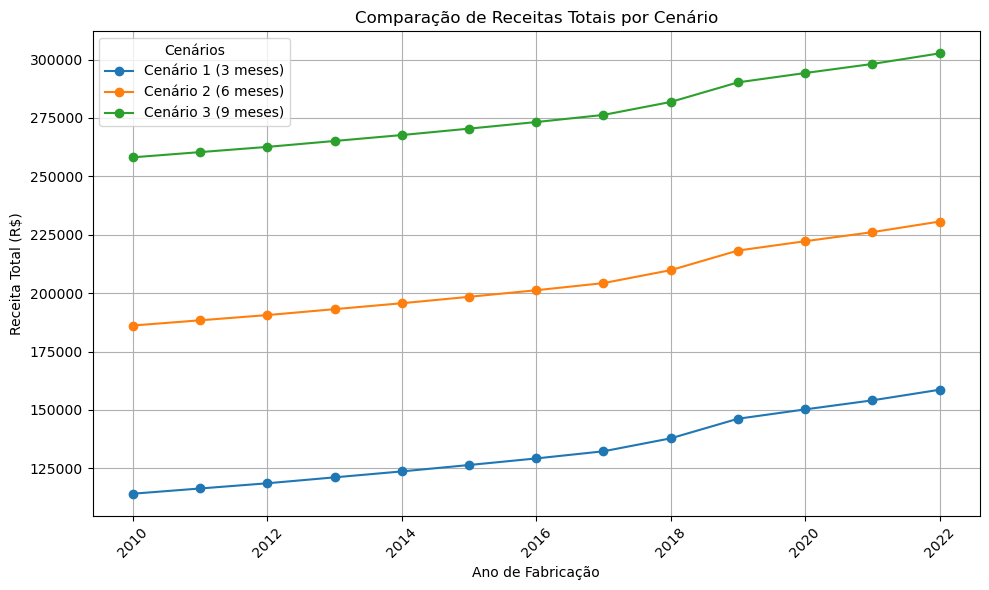

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados do arquivo 'db_vendas'
# Certifique-se de que o arquivo CSV está no local correto ou ajusta o caminho abaixo
db_vendas = db_alterado.copy()
# Definir os dados de depreciação fornecidos
preco_venda_preciso = {
    2010: 64212.02,
    2011: 67618.15,
    2012: 71019.76,
    2013: 74879.23,
    2014: 78750.48,
    2015: 82928.09,
    2016: 87229.83,
    2017: 91884.91,
    2018: 100345.81,
    2019: 113121.75,
    2020: 119227.88,
    2021: 125138.14,
    2022: 132054.63
}

# Parâmetros da simulação
valor_medio_aluguel = 6000  # Valor médio mensal de aluguel
taxa_desvalorizacao_anual = 0.10  # 10% de desvalorização por ano
duracao_aluguel = 48  # 48 meses

# Função para calcular a receita de aluguel acumulada
def calcular_receita_aluguel(valor_medio_aluguel, meses_alugados_por_ano, anos_em_uso):
    return valor_medio_aluguel * meses_alugados_por_ano * anos_em_uso

# Função para calcular o valor de venda após 4 anos, considerando desvalorização
def calcular_valor_venda(preco_inicial, taxa_desvalorizacao_anual, anos_em_uso):
    taxa_desvalorizacao_total = 1 - (1 - taxa_desvalorizacao_anual) ** anos_em_uso
    return preco_inicial * (1 - taxa_desvalorizacao_total)

# Lista de cenários: 3 meses, 6 meses, 9 meses alugados por ano
cenarios_aluguel = {"Cenário 1 (3 meses)": 3, "Cenário 2 (6 meses)": 6, "Cenário 3 (9 meses)": 9}

# Simulação para cada cenário e ano de fabricação
resultados_cenarios = []

for cenario_nome, meses_alugados_por_ano in cenarios_aluguel.items():
    for ano_fabricacao, preco_venda in preco_venda_preciso.items():
        # Calcular o valor de venda após 4 anos
        valor_venda_previsto = calcular_valor_venda(preco_venda, taxa_desvalorizacao_anual, 4)
        
        # Calcular a receita de aluguel por cenário
        receita_aluguel = calcular_receita_aluguel(valor_medio_aluguel, meses_alugados_por_ano, 4)
        
        # Receita total = receita de aluguel + valor de venda previsto
        receita_total = receita_aluguel + valor_venda_previsto
        
        # Guardar os resultados
        resultados_cenarios.append({
            "Cenário": cenario_nome,
            "Ano de Fabricação": ano_fabricacao,
            "Receita de Aluguel (4 anos)": receita_aluguel,
            "Valor de Venda Previsto": valor_venda_previsto,
            "Receita Total (Aluguel + Venda)": receita_total
        })

# Criar um DataFrame para organizar os resultados
df_resultados = pd.DataFrame(resultados_cenarios)

# Gerar gráficos comparando os cenários
plt.figure(figsize=(10, 6))

# Gráfico de Receita Total por cenário e ano de fabricação
for cenario in cenarios_aluguel.keys():
    subset = df_resultados[df_resultados['Cenário'] == cenario]
    plt.plot(subset['Ano de Fabricação'], subset['Receita Total (Aluguel + Venda)'], marker='o', label=cenario)

plt.title('Comparação de Receitas Totais por Cenário')
plt.xlabel('Ano de Fabricação')
plt.ylabel('Receita Total (R$)')
plt.legend(title='Cenários')
plt.grid(True)
plt.xticks(rotation=45)

# Exibir o gráfico
plt.tight_layout()
plt.show()
